# Detección de anomalías
---
Usaremos un fichero de datos correspondiente a consumo eléctrico en distintos puntos de medida. A partir de este consumo, seremos capaces de detectar anomalías en las distintas curvas de consumo y de esta forma, conociendo la ubicación de los puntos, conocer qué zonas de EEUU son más susceptibles a anomalías.

# Librerias
---

In [20]:
# Librerias manipulación
import pandas as pd
import numpy as np
import json
from pandas.io.json import json_normalize
import warnings
warnings.filterwarnings('ignore')
from datetime import datetime, timedelta
from itertools import product

# Librerias visualización
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (32.0, 15.0)
import seaborn as sns
from bokeh.plotting import figure, output_file, show
from bokeh.io import output_notebook
import folium
from folium.plugins import MarkerCluster, TimestampedGeoJson
%matplotlib inline
plt.rcParams['figure.figsize'] = (32.0, 15.0)

# Recopilación de la información
---

Deberemos indicar para qué variable queremos detectar anomalías.

In [2]:
df_points = pd.read_csv('example_comsumption.csv', sep=",", index_col=0)

In [3]:
df_points.head()

,point_id,city,state,latitude,longitude,timestamp,value
0,702610,Fairbanks,AK,64.83778,-147.71639,2013-01-01 01:00:00,1.345049
1,702610,Fairbanks,AK,64.83778,-147.71639,2013-01-01 02:00:00,1.223677
2,702610,Fairbanks,AK,64.83778,-147.71639,2013-01-01 03:00:00,1.176375
3,702610,Fairbanks,AK,64.83778,-147.71639,2013-01-01 04:00:00,1.163767
4,702610,Fairbanks,AK,64.83778,-147.71639,2013-01-01 05:00:00,1.163812


# Lógica para la detección de valores anómalos
---
**¿Cúando un dato es anómalo?** Consideraremos la estrategia de la `ventana deslizante` (**Sliding Window**). Con esta técnica, iremos construyendo dos curvas (intervalos, inferior y superior) para cada serie temporal. Esos intervalos se construyen a medida que se analiza cada punto de la serie de manera que, para un punto _x_, se fijarán dos nuevos puntos `(x.rolling(window).mean() - (sigma * x.rolling(window).std())`, donde:

* **window:** determina el intervalo de tiempo (por ejemplo, nº de días atrás) a partir del cual nos vamos a basar para determinar si la observación a clasificar es anómala o no.

* **sigma:** parámetro de sensibilidad; cuánto más mayor sea menos reestrictivos estamos siendo en la consideración de un valor anómalo.

A partir de este intervalo, tendremos la potestad para clasificar a la observación como atípica o no.

In [4]:
def obtain_anomaly_values(df, var_obj, window, sigma, save_csv_anomalies):
    dataset = df.copy()
    dataset['inf'] = dataset[var_obj].rolling(window=window).mean() - (sigma * dataset[var_obj].rolling(window=window).std())
    dataset['sup'] = dataset[var_obj].rolling(window=window).mean() + (sigma * dataset[var_obj].rolling(window=window).std())
    dataset = dataset.sort_index()
    dataset['anomalia'] = dataset.apply(
        lambda row: row[var_obj] if (row[var_obj]<=row['inf'] or row[var_obj] >= row['sup']) else None, axis = 1)
    dataset[[var_obj, 'inf', 'sup', 'anomalia']]
    n_anomalos = sum(dataset.apply(
                    lambda row: 1 if (row[var_obj]<=row['inf'] or row[var_obj]>=row['sup']) else 0, 
                            axis = 1))
    pct_anomalos = round((n_anomalos / dataset.shape[0]), 2)  
    if save_csv_anomalies:
        dataset_anomalies = dataset[dataset.anomalia.notnull()]
        city = list(dataset_anomalies.city.unique())[0]
        dataset_anomalies = dataset_anomalies[['timestamp', var_obj]]
        dataset_anomalies = dataset_anomalies.rename(columns={var_obj:'value'})
    return dataset, pct_anomalos, n_anomalos

# Detección de anomalías para cada punto de análisis
---
Función que evalúa la detección de anomalías para cada punto disponible. Almacenaremos en un dataframe el conteo de valores anómalos para cada señal y guardaremos en local un csv para cada punto de medida donde obtenemos los valores anómalos (con fecha y valor respectivo).

In [10]:
def obtain_anomalies_data_by_id_point(df_points):
    summary_anomalies_detection = pd.DataFrame()
    df_points_uniques = df_points['point_id'].drop_duplicates().reset_index(drop=True)
    count=0
    for i in range(df_points_uniques.shape[0]):
        id_point = df_points_uniques[i]
        df_point_city = df_points[df_points.point_id == id_point].\
                        sort_values(by='timestamp').drop('point_id', axis=1).reset_index(drop=True)
        city = df_point_city.city.unique()[0]
        latitude = df_point_city.latitude.unique()[0]
        longitude = df_point_city.longitude.unique()[0]
        df_point_city.index = pd.to_datetime(df_point_city.timestamp)
        df_point_city['previous_values'] = df_point_city['value'].\
                                                    rolling(window = 20, center=True, min_periods=1).median()
        df_point_city['previous_values'].update(df_point_city['value'])
        df_point_city_anomalies, pct_anomalies_city, count_anomalies = obtain_anomaly_values(
                df = df_point_city, var_obj = 'previous_values', window = 20, sigma = 2, 
                save_csv_anomalies = True)
        
        df_summary_city = pd.DataFrame({'city': city, 'latitude': latitude, 'longitude': longitude, 
                                        'anomalies': [count_anomalies]})
        summary_anomalies_detection = pd.concat([summary_anomalies_detection, df_summary_city], axis=0)
        count += 1
    print("Total de procesos de detección de anomalías:", count)
    return summary_anomalies_detection

In [11]:
summary = obtain_anomalies_data_by_id_point(df_points)

Total de procesos de detección de anomalías: 57


## Señalización en el mapa en función del número de valores anómalos
---
Para ello, y teniendo cuenta el conteo total de las anomalías para cada punto de medida, estableceremos una escala posible de valores. En primer lugar realizaremos un estudio individualizado y posteriormente a nivel de estado.

In [12]:
print("Mínimo número de anomalías por punto detectadas: ", summary['anomalies'].min())
print("Máximo número de anomalías por punto detectadas:", summary['anomalies'].max())

Mínimo número de anomalías por punto detectadas:  517
Máximo número de anomalías por punto detectadas: 1294


In [13]:
colours = ['lightgreen', 'lightblue', 'beige', 'cadetblue', 'blue', 'darkblue']

In [14]:
def color_coding(value_min, value_max, row):
    numero_intervalos = 6
    rango = value_max - value_min
    tamano_intervalo = rango / 6
    if row['anomalies'] >= value_min and row['anomalies'] < (value_min + tamano_intervalo * 1):
        return colours[0]

    elif row['anomalies'] >= (value_min + tamano_intervalo * 1) and row['anomalies'] < (value_min + tamano_intervalo * 2):
        return colours[1]

    elif row['anomalies'] >= (value_min + tamano_intervalo * 2) and row['anomalies'] < (value_min + tamano_intervalo * 3):
        return colours[2]

    elif row['anomalies'] >= (value_min + tamano_intervalo * 3) and row['anomalies'] < (value_min + tamano_intervalo * 4):
        return colours[3]

    elif row['anomalies'] >= (value_min + tamano_intervalo * 4) and row['anomalies'] < (value_min + tamano_intervalo * 5):
        return colours[4]
    elif row['anomalies'] >= (value_min + tamano_intervalo * 5) and row['anomalies'] <= (value_min + tamano_intervalo * 6):
        return colours[5]
    
summary['color'] = summary.apply(lambda row: color_coding(summary['anomalies'].min(), 
                                                          summary['anomalies'].max(), row), axis=1)
summary.head()

,city,latitude,longitude,anomalies,color
0,Fairbanks,64.837780,-147.716390,1256,darkblue
0,Kotzebue,66.897222,-162.583333,1225,darkblue
0,Mobile,30.727669,-88.052672,573,lightgreen
0,FortSmith,35.350000,-94.366667,586,lightgreen
0,Flagstaff,35.198070,-111.651270,1289,darkblue


### Caracterización de los puntos de medida por número de anomalías
---

In [15]:
USA_coordinates = (45.0000000, -97.0000000)
m = folium.Map(location=USA_coordinates, zoom_start = 3, tiles = "OpenStreetMap")

def insert_city_and_anomalies(summary_anomalies):
    for i in range(summary_anomalies.shape[0]):
        folium.Marker(location = (float(summary_anomalies.iloc[i,1]), float(summary_anomalies.iloc[i,2])),
                      tooltip = summary_anomalies.iloc[i,0], icon=folium.Icon(color=summary_anomalies.iloc[i,-1]), 
                      popup = 'Anomalies:' + str(summary_anomalies.iloc[i,3])).add_to(m)
insert_city_and_anomalies(summary)
m

### Agrupación por estado: conteo del número de anomalías
---
Distinguimos dos agrupaciones: conteo total por estado y nº medio de anomalías por estado teniendo en cuenta aquí el número de puntos de análisis

#### Número total de anomalías en los 50 estados de EEUU
---

In [16]:
group_state = summary.merge(df_points[['city', 'state']], on=['city'], how="left").drop_duplicates().reset_index(drop=True)
group_state_sum = group_state.groupby(['state'])['anomalies'].sum()
group_state_mean = group_state.groupby(['state'])['anomalies'].mean()
group_state_sum = group_state_sum.reset_index(['state']).reset_index(drop=True)
group_state_sum = group_state_sum.rename(columns={'anomalies':'sum_anomalies'})
group_state_mean = group_state_mean.reset_index(['state']).reset_index(drop=True)
group_state_mean = group_state_mean.rename(columns={'anomalies':'avg_anomalies'})
group_state_full = group_state_sum.merge(group_state_mean, on = 'state')

url = 'https://raw.githubusercontent.com/python-visualization/folium/master/examples/data'
state_geo = f'{url}/us-states.json'
USA_coordinates = (45.0000000, -97.0000000)
m = folium.Map(location=USA_coordinates, zoom_start = 3, tiles = "OpenStreetMap")
m.choropleth(
 geo_data=state_geo,
 name='choropleth',
 data=group_state_full,
 columns=['state', 'sum_anomalies'],
 key_on='feature.id',
 fill_color='YlGn',
 fill_opacity=0.7,
 line_opacity=0.2,
 legend_name='Total de anomalias por estado'
)
folium.LayerControl().add_to(m)
m

#### Promedio del número de valores anómalos por estado
---

In [17]:
m_avg = folium.Map(location=USA_coordinates, zoom_start = 3, tiles = "OpenStreetMap")
m_avg.choropleth(
 geo_data=state_geo,
 name='choropleth',
 data=group_state_full,
 columns=['state', 'avg_anomalies'],
 key_on='feature.id',
 fill_color='YlGn',
 fill_opacity=0.7,
 line_opacity=0.2,
 legend_name='Promedio del numero de anomalias por estado en funcion del numero de puntos'
)
folium.LayerControl().add_to(m_avg)
m_avg

# Representación gráfica de las anomalías de cada punto de medida
---

Visualización, a lo largo del mes indicado, de la serie temporal para el punto indicado observando la existencia de las anomalías. Ejemplo: `Miami`

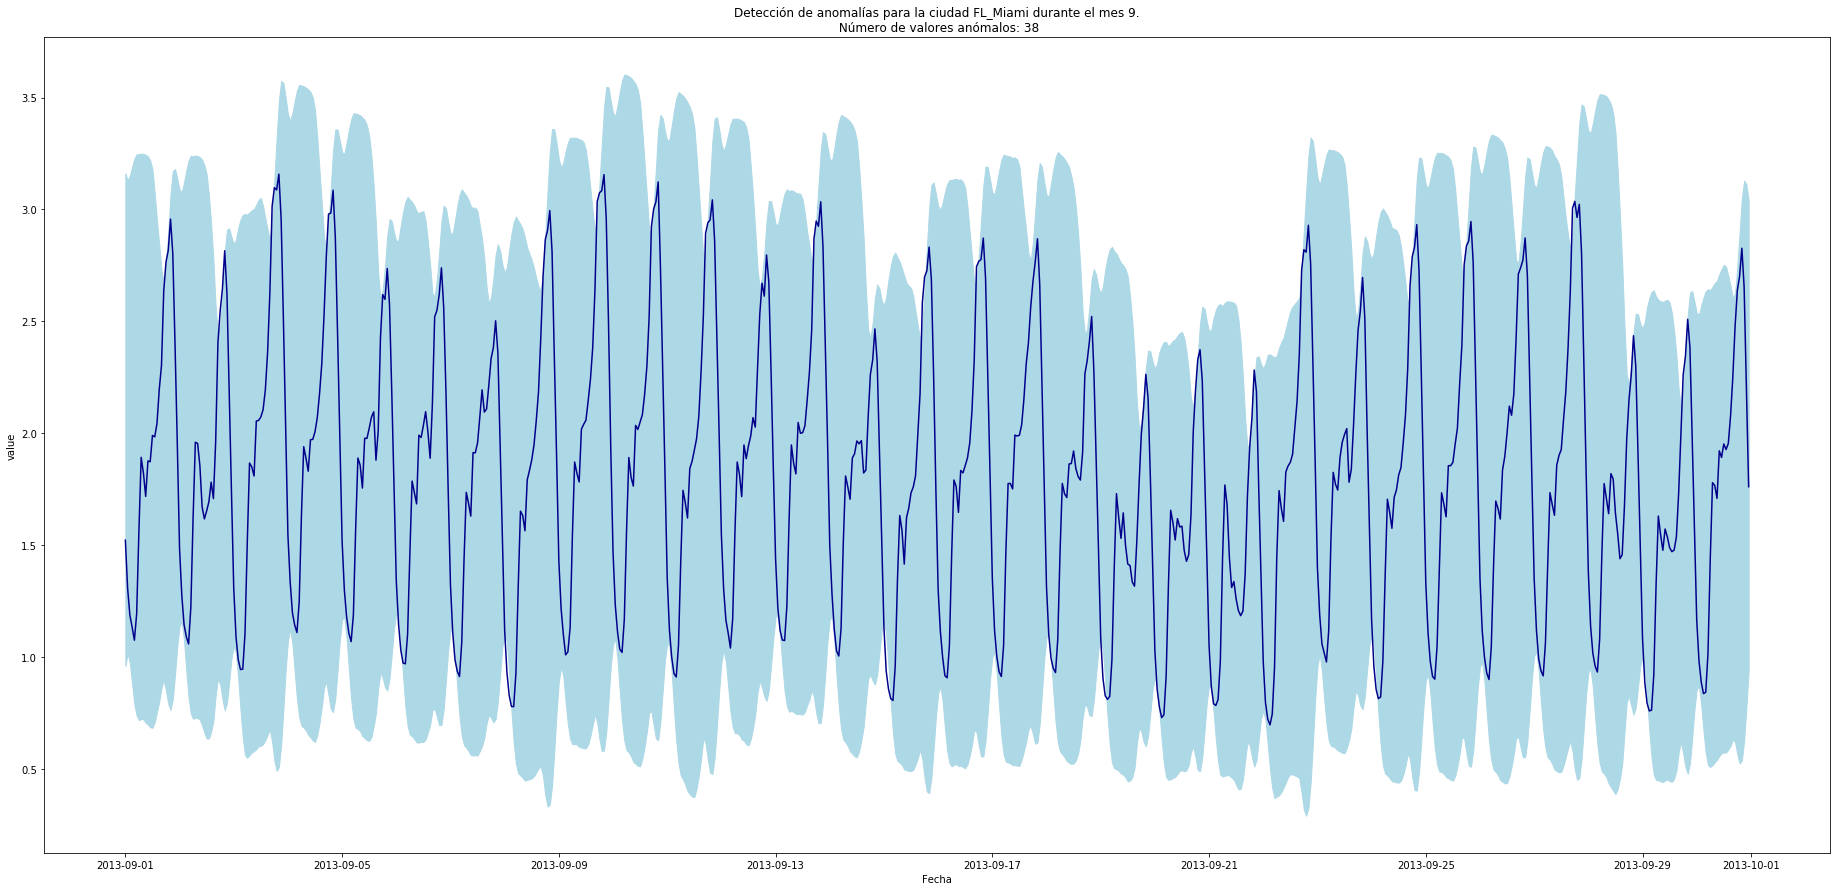

In [21]:
def obtain_data(df, city):
    df_point = df[df.city == city][['state', 'city', 'timestamp', 'value']]
    df_point_anomalies, pct, count = obtain_anomaly_values(df_point, 'value', 20, 2, save_csv_anomalies=False)
    df_point_anomalies.index = pd.to_datetime(df_point_anomalies['timestamp'])
    df_point_anomalies['month'] = df_point_anomalies.index.month
    df_point_anomalies.drop('timestamp', axis=1, inplace=True)
    return df_point_anomalies

def graph_month_anomalies_by_city(df, month):
    df_plot_month = df.copy()
    city = list(df_plot_month['city'].unique())[0]
    state = list(df_plot_month['state'].unique())[0]
    df_plot = df_plot_month[df_plot_month.month == month]
    if month == 1:
        df_plot = df_plot.iloc[:-1,:]
    plt.fill_between(df_plot.index, df_plot['inf'], df_plot['sup'], color="lightblue")
    sns.lineplot(df_plot.index, df_plot['value'], color="darkblue")
    plt.title('Detección de anomalías para la ciudad ' + state + '_' + df['city'].unique()[0] + 
              ' durante el mes ' + str(month) + 
              '.\n Número de valores anómalos: ' + str(df_plot[df_plot['anomalia'].notnull()].shape[0]))
    plt.xlabel('Fecha')
    plt.show()
    
df_anomalies_city = obtain_data(df_points, 'Miami')
graph_month_anomalies_by_city(df_anomalies_city, 9)